# Evaluating the Inverse of Analyzer Matrix Using Linear Regression
Solving the problem: S = A*I . Evaluate Ainv using sklearn's Linear Regression object which uses least suqares approximation. A is what is calculated by a least squares fit. Single $\mathbf{A}$ for each cam based on average intensity over a central image patch

Input is images for all the 3 cameras taken with different angles of the source polarizer

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.linear_model import LinearRegression
import os
from os.path import dirname, join as pjoin
import scipy.io as sio
from collections import defaultdict
import os.path


In [23]:
def readRawImg(cam):
    """
    Function to read all the rescaled image files for cam (1, 2, or 3) -- 
    note that these images are cropped (and if geometric and radiometric calibration paramaters are available, applied those too) 
    and  MOST IMPORTANTLY, these images are "pre-registered" -- i.e. they all have been corrected to map corresponding pixels onto each other
    Read these images directly from the `final_map.mat` file which has the registered version of the images with the appropriate ROI
        args: cam: int: which camera id
        return matrix of all the images for a given camera and the image shape
    """
    
    # simple version for working with CWD to print number of files
    numFiles = 18
    
    data_dir = pjoin('..')
    mat_fname = pjoin(data_dir, 'final_map_Analyzer.mat')
    arrays = {}
    f = h5py.File(mat_fname)
    for k, v in f.items():
        arrays[k] = np.array(v).T
    print('image_array_shape is : ', arrays[k].shape)
    allImg = arrays[k][:,:,cam-1,:]
    fig, ax = plt.subplots()
    a = ax.imshow(allImg[:,:,1])
    ax.set_title('Camera {}'.format(str(cam)))
    fig.colorbar(a)
    plt.show()
    
    return allImg

In [24]:
def rescaleImg(images, factor):
    """
    Function to rescale all images for values between 0-1
        args: images: matrix of all images
    """
    return images/factor

In [25]:
def img2SrcPolarizerAngle():
    """
    Function that describes and returns the source polarizer to image sequence mapping
    Values are Hard-coded in this func
    Angles are in degrees
        return: ordered list with polar angles corresponding to images 
    """
    # there are as many angles as there are numFiles
    lst = np.array(np.arange(0,180, 10)) # to be tweaked based on how you took lab data
    print("angles are : ", lst)
    return lst

In [26]:
def getY(angles):
    """
    Create the inputs X: Each row of returned X is the intensity measured by camera 1, camera 2, and camera 2 resp.
        return: X
    """
    y = np.zeros((len(angles),3))
    y[:,0] = np.ones((len(angles))) 
    y[:,1] = np.cos(2*angles*np.pi/180).reshape((len(angles), )) #
    y[:,2] = np.sin(2*angles*np.pi/180).reshape((len(angles), )) #
    return y

In [27]:
def getX(angles, r, c, imgs):
    """
    Function to return the y for the regression fit. Here this is the theoretically known Stokes Vector component
        return : y
    """
    #len(angles)==numFiles
    X = np.zeros((3,len(angles)))
    X[0,:] = imgs[1][r,c,:]
    X[1,:] = imgs[2][r,c,:]
    X[2,:] = imgs[3][r,c,:]
    return X.T

In [47]:
def getRegCoeffs(r, c, imgs, angles):
    """
    Function to evaluate the regression coefficients of Ainv for the regression S = Ainv*I 
        args: 
            prow, pcol: row and col location of pixel for which regression happens
            imgs: dictionary of images from all 3 cameras
            cam: which camera are you calculating the regression for
            angles: the angles on the source polarizer sheet corresponding to which the images were taken
        return : regression coeffs
    """
    X = getX(angles, r, c, imgs)
    y = getY(angles)
#     print("X.shape is  = ", X.shape)
#     print("y.shape is  = ", y.shape)
#     print(X)
#     print(y)
    reg = LinearRegression(fit_intercept= False).fit(X, y)
    print("Coefficient of determination R^2 : ",reg.score(X, y))
    coeffs = reg.coef_
#     print("Coefficients are : ", coeffs)
#     print("prediction : ",reg.predict(np.array([1, 0.5, 0.5]).reshape(-1, 1)))
    
    return coeffs

## Read Images
Note that the order of the `imgs` dictionary is always cameras from left to right (C6:1, C7:2, C2:3) but the argument for the `readRawImg` is the corresponding numeric key (argument on the right hand side) for the camera used in matlab when creating the video input object. Be sure to verify what acquisition time parameters are used in matlab. So for the code below `imgs[2]` is corresponding to stream `s2` (because its argument is `2`). Stream `s2` is saved as `Cam_2` images irrespective of the argument on RHS below

```
v1 = videoinput('gige',1, 'Mono8'); % C6    
s1 = v1.Source;
v2 = videoinput('gige',2, 'Mono8'); % C7
s2 = v2.Source;
v3 = videoinput('gige',3, 'Mono8'); % C2
s3 = v3.Source;
```

image_array_shape is :  (186, 215, 3, 18)


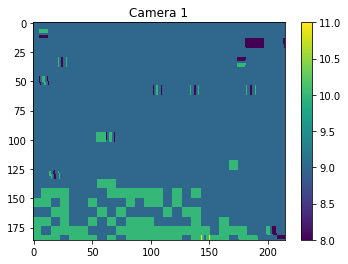

(186, 215)
image_array_shape is :  (186, 215, 3, 18)


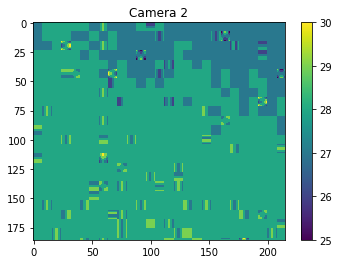

image_array_shape is :  (186, 215, 3, 18)


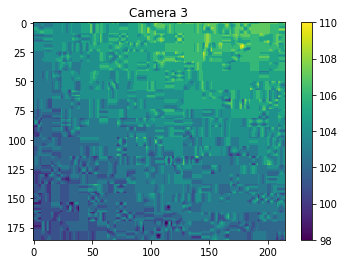

In [50]:
factor = 1
cols = 215
rows = 186
temp = readRawImg(1)
holder1 = np.zeros((temp.shape[0], temp.shape[1]))
print(holder1.shape)
imgs = dict([(1,holder1), (2,holder1), (3,holder1)])
imgs[1] = rescaleImg(temp, factor)
imgs[2] = rescaleImg(readRawImg(2), factor)
imgs[3] = rescaleImg(readRawImg(3), factor)

## Calculate angles

In [51]:
angles = img2SrcPolarizerAngle()

angles are :  [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170]


## Evaluate & Validate the Coefficients of regression
 (Single $\mathbf{A}$ for each cam based on average intensity over a central image patch)

**Note that the Analyzer matrix calculation is nearly constant for all pixels over the 3 images. So you can just average all pixel intensities or take a central well illuminated patch. Basically this averaging technique as implemented in this code allays the need for a pixel-wise Analyzer matrix**

To verify above, I tweaked the averaging patch size and location by varying the patch's edge locations. The $r^2$ is very high in all cases (even for a single pixeled size patch

In [52]:
lst = [[None]*cols]*rows # store all analyzer matrices here

In [ ]:
for r in range(186):
    for c in range(215):
        # Evaluate the Analyzer matrix
        A = getRegCoeffs(r, c, imgs, angles)
        Ainv = np.linalg.inv(A)
        
        # Validation
        S0_theory = np.ones(angles.shape)
        S1_theory = np.cos(2*angles*np.pi/180)
        S2_theory = np.sin(2*angles*np.pi/180)

        I_measured = getX(angles, r, c, imgs)
        S_calc = A @ I_measured.T
        
        lst[r][c] = A

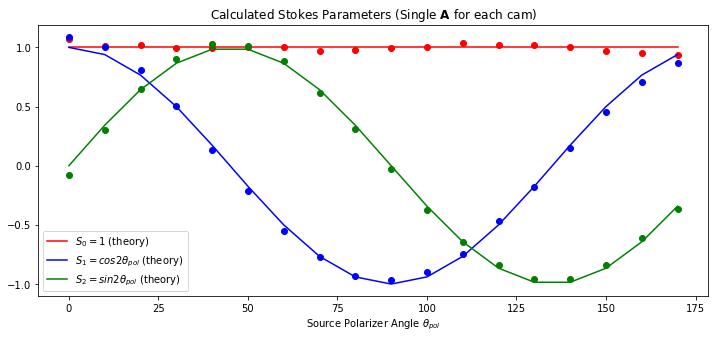

In [32]:
plt.figure(figsize = (12,5))
plt.plot(angles, S0_theory, 'r-', label = '$S_0 = 1$ (theory)')
plt.plot(angles, S_calc[0,:], 'ro')
plt.plot(angles, S1_theory, 'b-', label = '$S_1 = cos 2\\theta_{pol}$ (theory)')
plt.plot(angles, S_calc[1,:], 'bo')
plt.plot(angles, S2_theory, 'g-', label = '$S_2 = sin 2\\theta_{pol}$ (theory)')
plt.plot(angles, S_calc[2,:], 'go')
plt.legend()
plt.xlabel('Source Polarizer Angle $\\theta_{pol}$')
plt.title('Calculated Stokes Parameters (Single $\mathbf{A}$ for each cam)' )#based on average intensity over a central image patch)')
plt.show()

In [54]:
sio.savemat('../analyzerMatrix.mat', {'analyzerMatrices': lst})

In [ ]:
sio.loadmat('../analyzerMatrix.mat')